What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and attribute any extra to a different, missing process?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

import scripts as sc # Python scripts containing helper functions

Test modules:

In [2]:
NH4_ambient = 50.0 # nmol/L
d15NH4_ambient = 7.0 # per mil, assume
__, _, af = sc.convert_delta(NH4_ambient, d15NH4_ambient)
print(af)

0.0036885495224455744


In [3]:
af_spike = 0.999
_, d15N_spike = sc.convert_af(af_spike)
print(d15N_spike)

271727043.47646296


In [4]:
print(sc.binomial(0.99, 0.40))

(0.396, 0.594, 0.0040000000000000036, 0.006000000000000005)


In [98]:
data = sc.read_data('00_incubationdata.csv')

timepoints = sc.get_experiment(data=data,
                                 station="PS2", feature="SCM", tracer="NO2-")

timepoints['timepoint'] = round(timepoints.x,0)

timepoints

,Incubation_time_hrs,44N2O,45N2Oa,45N2Ob,46N2O,x,timepoint
0,0.283333,17.287897,0.079703,0.067088,0.038824,11.805556,12.0
1,11.733333,17.300354,0.151967,0.060203,0.074242,488.888889,489.0
2,24.083333,17.855326,0.183157,0.055270,0.103027,1003.472222,1003.0


In [110]:
def grid_data(data, T, yvar, interptype):
    
    # data = output from "read_data": Pandas DataFrame object w/
    # ...averaged isotopomer data from three timepoints + incubation time in hours
    # T = number of timepoints in the model, typically 1000
    # yvar = column in "data": "44N2O", "45N2Oa", "45N2Ob", or "46N2O"
    # interptype = "linear", "quadratic", etc.
    
    data['x'] = data.Incubation_time_hrs/24*T # time(timepoints) = time(hrs) * (1 day/24 hrs) * (T timepoints/day)
    data['timepoint'] = round(data.x,0) # round timepoints to nearest integer to match w/ model output
    
    # get evenly-spaced integers that can match up with model timepoints
    xmin = int(data.timepoint.min()) # first incubation timepoint corresponds to this model timepoint (say, 12)
    xmax = int(data.timepoint.max()) # last incubation timepoint corresponds to this model timepoint (say, 1003)
    xfine = np.linspace(xmin,xmax,(xmax-xmin+1)) # gridded integer timepoints separated by 1

    x = timepoints.timepoint # define variables over which to perform interpolation
    y = timepoints[yvar]

    interpolated_data = np.array(interp.interp1d(x,y,kind="quadratic")(xfine)) # interpolate data over gridded timepoints
    
    n_gridpoints = T - xmin # we're going to cut off interpolated data at timepoint T (e.g. 1000)
    
    gridded_data = interpolated_data[:n_gridpoints].reshape(n_gridpoints, 1) # reshape from (n,) to (n,1) to compare with model output
    
    return gridded_data

In [113]:
def calculate_error(measured_data, modeled_data, T):

    starting_timepoint = T - len(measured_data) # infer first incubation timepoint from length of measured data array

    modeled_data = modeled_data[starting_timepoint:] # cut all previous timepoints off of model output for comparison

    error = measured_data - modeled_data # compute rmse from the two numpy arrays
    squarederror = error**2
    mse = np.sum(squarederror)/len(squarederror)
    rmse = np.sqrt(mse)
    
    return rmse

In [114]:
calculate_error(grid_data(timepoints, T, '46N2O', "quadratic"), n2o_45a, T)

0.06958245043411895

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

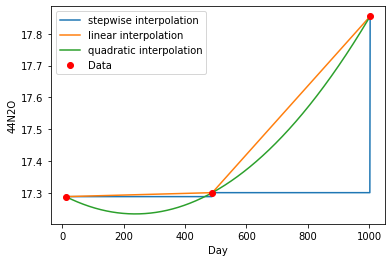

In [117]:
### TRY THREE DIFFERENT INTERPOLATION METHODS ###
data = sc.read_data('00_incubationdata.csv')

timepoints = sc.get_experiment(data=data,
                                 station="PS2", feature="SCM", tracer="NO2-")
timepoints['timepoint'] = round(timepoints.x,0)

xmin = int(timepoints.timepoint.min())
xmax = int(timepoints.timepoint.max())

xfine = np.linspace(xmin,xmax,(xmax-xmin+1)) # this gives us evenly-spaced integers that can match up with model timepoints

x = timepoints.timepoint
y = timepoints['44N2O']
x_fine = xfine # get a range of x to interpolate over

fig, ax = plt.subplots()

# the scipy interp package lets us interpolate between points in different ways
ax.plot(x_fine,interp.interp1d(x,y,kind="zero")(x_fine), label="stepwise interpolation")
ax.plot(x_fine,interp.interp1d(x,y,kind="linear")(x_fine), label="linear interpolation")
ax.plot(x_fine,interp.interp1d(x,y,kind="quadratic")(x_fine), label="quadratic interpolation")
ax.plot(x,y,'ro', label="Data")
#ax.set_ylim([0, 6]) # a common y-axis range will let us compare plots

# make our plot nice with axis labels, a legend, and a title
ax.legend()
ax.set_xlabel("Day")
ax.set_ylabel('44N2O')

# store interpolation results
interpolated = pd.DataFrame([])

In [118]:
### INITS ###

### STATION SPECIFIC ###

"""
Station: PS2
Feature: Secondary chlorophyll max
Tracer: 15NO2-
"""

N2O_init = 17.287897 # nmol/L; these are the initial values measured in the 15NO2- experiment, specifically
N2O45a_init = 0.079703 # nmol/L
N2O45b_init = 0.067088 # nmol/L
N2O46_init = 0.038824 # nmol/L

NH4_ambient = 50.0 # nmol/L
NO2_ambient = 0.027885*1000 #nmol/L
NO3_ambient = 28.101655*1000 # nmol/L

d15NH4_ambient = 7.0 # per mil, assume
d15NO2_ambient = -22.82 # per mil, PS2 sigma-theta=26.27
d15NO3_ambient = 15.25 # per mil, PS2 sigma-theta=26.27

__, _, afNH4_ambient = sc.convert_delta(NH4_ambient, d15NH4_ambient)
__, _, afNO2_ambient = sc.convert_delta(NO2_ambient, d15NO2_ambient)
__, _, afNO3_ambient = sc.convert_delta(NO3_ambient, d15NO3_ambient)

### NON-STATION SPECIFIC ###

NH4_carrier = 0.50*1000 # nmol/L; THESE ARE TRUE FOR ALL EXPERIMENTS
NO2_carrier = 1.00*1000 # nmol/L
NO3_carrier = 0.0 # nmol/L

R15std = 0.00367647 # air N2
af_carrier = R15std/(1+R15std)

NH4_spike = 0.50*1000 # nmol/L; THESE ARE TRUE FOR ALL EXPERIMENTS
NO2_spike = 4.80*1000 # nmol/L
NO3_spike = 1.00*1000 # nmol/L

af_spike = 0.99999999
_, d15N_spike = sc.convert_af(af_spike)

### ISOTOPE MIXING - TRACER ###

NO2_init = NO2_ambient + NO2_spike # nmol/L
AFNO2_init = (afNO2_ambient*NO2_ambient + af_spike*NO2_spike)/NO2_init
_, d15NO2_init = sc.convert_af(AFNO2_init)

### ISOTOPE MIXING - NATURAL ABUNDANCE SPECIES ###

NH4_init = NH4_ambient + NH4_carrier # nmol/L
AFNH4_init = (afNH4_ambient*NH4_ambient + af_carrier*NH4_carrier)/NH4_init
_, d15NH4_init = sc.convert_af(AFNH4_init)

NO3_init = NO3_ambient + NO3_carrier # nmol/L
AFNO3_init = (afNO3_ambient*NO3_ambient + af_carrier*NO3_carrier)/NO3_init
_, d15NO3_init = sc.convert_af(AFNO3_init)

### NON-MEASURED SPECIES ###

NO_init = 0.0 # assume that NO starts at 0
d15NO_init = 0.0

NH2OH_init = 0.0 # assume that NH2OH starts at 0
d15NH2OH_init = 0.0

N2_init = 0.0 # assume that N2 starts at 0
d15NO_init = 0.0

In [119]:
### RATE CONSTANTS ###

### SUBSTRATE EXCHANGE ###

kNH4TONO2 = 0.539726351/(NH4_ambient + NH4_spike)
kNO2TONO3 = 73.23197829/(NO2_ambient + NO2_spike)
kNO3TONO2 = 25.74033006/(NO3_ambient + NO3_spike)

kNH4toNH2OH = kNH4TONO2
kNH2OHtoNO = kNH4TONO2

### N2O CONSUMPTION ###

kN2OCONS = 0.056 # /day

### MEASURED RATES OF N2O PRODUCTION ###

kNO2TON2Oa = 0.112/(NO2_spike) # these are the rates measured in the 15NO2- experiment
kNO2TON2Ob = 0.000/(NO2_spike)
kNO2TO46N2O = 0.067/(NO2_spike)

kNO3TON2Oa = 0.019/(NO3_spike) # these are the rates measured in the 15NO3- experiment
kNO3TON2Ob = 0.017/(NO3_spike)
kNO3TO46N2O = 0.004/(NO3_spike)

kNH4TON2Oa = 0.000/(NH4_spike) # these are the rates measured in the 15NH4+ experiment
kNH4TON2Ob = 0.003/(NH4_spike)
kNH4TO46N2O = 0.000/(NH4_spike)

### ASSUMED RATES OF N2O PRODUCTION ###

kdenitno2 = 0.067/(NO2_spike + NO2_ambient)/(0.994245**2)
kdenitno3 = 0.004/(NO3_spike + NO3_ambient)/(0.034362**2)
khybridnh4 = 0.003/(NH4_spike + NH4_ambient)
khybridno2 = 0.112/(NO2_spike + NO2_ambient)

In [120]:
kdenitno3

0.00011640869925729138

In [121]:
# Isotope effects, translated into fractionation factors
alpha15NH4TON2Oa = -21.3/1000 + 1 # AOA, Santoro et al., 2011 (adjusted based on δ15NH4+ value)
alpha15NH4TON2Ob = 9.0/1000 + 1 # AOA, Santoro et al., 2011 (adjusted based on δ15NH4+ value)
alpha15NH4TON2O46 = (alpha15NH4TON2Oa + alpha15NH4TON2Ob)/2

alpha15NOxTON2Oa = 22./1000.+1 # Toyoda et al., 2005
alpha15NOxTON2Ob = 22./1000.+1 # Toyoda et al., 2005
alpha15NOxTON2O46 = 22./1000.+1 # Toyoda et al., 2005

alpha15NH4TONO2 = 22./1000+1 # AOA, Santoro and Casciotti, 2011
alpha15NO2TONO3 = -15./1000+1 # Casciotti, 2009
alpha15NO3TONO2 = 5./1000+1 # Granger et al., 2004

alpha15N2OatoN2 = 11.8/1000.+1 # Kelly et al., 2021
alpha15N2ObtoN2 = 0./1000.+1 # Kelly et al., 2021
alpha46N2OtoN2 = 11.8/1000.+1 # assume this is the same as the alpha effect

In [145]:
### INITIALIZE MODEL PARAMETERS ###

# time step (d)
dt = 0.001 # 0.001 days/timestep or 1,000 timesteps/day
#dt = 0.2 # 0.2 days/timestep or 5 timesteps/day

# number of timesteps (y)
# increasing n(timesteps) by a factor of 10 decreases rate constants by the same factor
T = 1000
times = np.array(list(range(1,T+1))) # vector of timesteps

### INITIALIZE STATE VARIABLES ###

# N2O state variables
n2o_44_i = N2O_init
n2o_45a_i = N2O45a_init
n2o_45b_i = N2O45b_init
n2o_46_i = N2O46_init
#n2o_16_i = 0.5*n2o_44_i # 2 nitrogen atoms per oxygen!
#n2o_18_i = R18n2o_i*n2o_16_i

# substrate state variables
nh4_14_i, nh4_15_i, _ = sc.convert_delta(concentration=NH4_init, d15N=d15NH4_init)
no2_14_i, no2_15_i, _ = sc.convert_delta(concentration=NO2_init, d15N=d15NO2_init)
no3_14_i, no3_15_i, _ = sc.convert_delta(concentration=NO3_init, d15N=d15NO3_init)

# initialize arrays of state variables
n2o_44 = np.zeros(shape = (T,1))
n2o_45a = np.zeros(shape = (T,1))
n2o_45b = np.zeros(shape = (T,1))
n2o_46 = np.zeros(shape = (T,1))
nh4_14 = np.zeros(shape = (T,1))
nh4_15 = np.zeros(shape = (T,1))
no2_14 = np.zeros(shape = (T,1))
no2_15 = np.zeros(shape = (T,1))
no3_14 = np.zeros(shape = (T,1))
no3_15 = np.zeros(shape = (T,1))
n2_28 = np.zeros(shape = (T,1))
n2_29 = np.zeros(shape = (T,1))
n2_30 = np.zeros(shape = (T,1))

afnh4 = np.zeros(shape = (T,1))
afno2 = np.zeros(shape = (T,1))
afno3 = np.zeros(shape = (T,1))

# initial values of state variables
n2o_44[0,:] = n2o_44_i
n2o_45a[0,:] = n2o_45a_i
n2o_45b[0,:] = n2o_45b_i
n2o_46[0,:] = n2o_46_i
nh4_14[0,:] = nh4_14_i
nh4_15[0,:] = nh4_15_i
no2_14[0,:] = no2_14_i
no2_15[0,:] = no2_15_i
no3_14[0,:] = no3_14_i
no3_15[0,:] = no3_15_i
n2_28[0,:] = 0
n2_29[0,:] = 0
n2_30[0,:] = 0

afnh4[0,:] = nh4_15_i/(nh4_14_i+nh4_15_i)
afno2[0,:] = no2_15_i/(no2_14_i+no2_15_i)
afno3[0,:] = no3_15_i/(no3_14_i+no3_15_i) 

### ISOTOPE CONSTANTS ###
R15std = 0.00367647 # air N2
R18std = 0.00200517 # VSMOW


### TIME STEPPING ###
for iT in range(T-1):

    # update substrate values
    nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
        -kNH4TONO2*nh4_14[iT]
    
        -khybridnh4*nh4_14[iT])
    
    nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
        -kNH4TONO2/alpha15NH4TONO2*nh4_15[iT]
    
        -khybridnh4*nh4_15[iT])
    
    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
    
    no2_14[iT+1,:] = no2_14[iT,:] + dt*(
        kNH4TONO2*nh4_14[iT]
        +kNO3TONO2*no3_14[iT]
        -kNO2TONO3*no2_14[iT]
        
        -khybridno2*no2_14[iT]
        -kdenitno2*no2_14[iT])
    
    no2_15[iT+1,:] = no2_15[iT,:] + dt*(
        kNH4TONO2/alpha15NH4TONO2*nh4_15[iT]
        +kNO3TONO2/alpha15NO3TONO2*no3_15[iT]
        -kNO2TONO3/alpha15NO2TONO3*no2_15[iT]
        
        -khybridno2*no2_15[iT]
        -kdenitno2*no2_15[iT])
    
    no3_14[iT+1,:] = no3_14[iT,:] + dt*(
        kNO2TONO3*no2_14[iT]
        -kNO3TONO2*no3_14[iT]
    
        -kdenitno3*no3_14[iT])
    
    no3_15[iT+1,:] = no3_15[iT,:] + dt*(
        kNO2TONO3/alpha15NO2TONO3*no2_15[iT]
        -kNO3TONO2/alpha15NO3TONO2*no3_15[iT]
    
        -kdenitno3*no3_15[iT])
    
    # recalculate atom fractions at each time step
    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
    afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
    afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])
    
    # calculate total rates of N2O production from substrates
    total_hybrid = (khybridnh4*nh4_14[iT]+khybridnh4*nh4_15[iT]+khybridno2*no2_14[iT]+khybridno2*no2_15[iT])
    total_denit_no2 = (kdenitno2*no2_14[iT] + kdenitno2*no2_15[iT])
    total_denit_no3 = (kdenitno3*no3_14[iT] + kdenitno3*no3_15[iT])
    
    # calculate probabilities of isotopomer formation
    p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])
    
    p46hybrid = p1
    p45ahybrid = (p2+p3)/2
    p45bhybrid= (p2+p3)/2
    p44hybrid = p4
    
    p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
    p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])
    
    # update N2O values
    n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
        +total_hybrid*p46hybrid
        +total_denit_no2*p46no2
        +total_denit_no3*p46no3
        -kN2OCONS/alpha46N2OtoN2*n2o_46[iT])
    
    n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
        +total_hybrid*p45ahybrid
        +total_denit_no2*p45ano2
        +total_denit_no3*p45ano3
        -kN2OCONS/alpha15N2OatoN2*n2o_45a[iT])
    
    n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
        +total_hybrid*p45bhybrid
        +total_denit_no2*p45bno2
        +total_denit_no3*p45bno3
        -kN2OCONS/alpha15N2ObtoN2*n2o_45b[iT])
    
    n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
        +total_hybrid*p44hybrid
        +total_denit_no2*p44no2
        +total_denit_no3*p44no3
        -kN2OCONS*n2o_44[iT])
    
    # update N2 values
    
    n2_28[iT+1,:] = n2_28[iT,:] + dt*(kN2OCONS*n2o_44[iT])
    
    n2_29[iT+1,:] = n2_29[iT,:] + dt*(
        kN2OCONS/alpha15N2OatoN2*n2o_45a[iT]
        +kN2OCONS/alpha15N2ObtoN2*n2o_45b[iT])
    
    n2_30[iT+1,:] = n2_30[iT,:] + dt*(kN2OCONS/alpha46N2OtoN2*n2o_46[iT])


In [156]:
p45ahybrid

array([0.49272395])

In [157]:
p45bhybrid

array([0.49272395])

In [147]:
### CALCULATE OUTPUT ###
nh4_concentration = pd.DataFrame(nh4_14+nh4_15, columns={'[NH4+]_nM'})
d15nh4 = pd.DataFrame((((nh4_15/(nh4_14))/R15std)-1)*1000, columns={'d15NH4+'})
afnh4 = pd.DataFrame(afnh4, columns={'AFNH4+'})

no3_concentration = pd.DataFrame(no3_14+no3_15, columns={'[NO3-]_nM'})
d15no3 = pd.DataFrame((((no3_15/(no3_14))/R15std)-1)*1000, columns={'d15NO3-'})
afno3 = pd.DataFrame(afno3, columns={'AFNO3-'})

no2_concentration = pd.DataFrame(no2_14+no2_15, columns={'[NO2-]_nM'})
d15no2 = pd.DataFrame((((no2_15/(no2_14))/R15std)-1)*1000, columns={'d15NO2-'})
afno2 = pd.DataFrame(afno2, columns={'AFNO2-'})


n2o_concentration = pd.DataFrame(n2o_44+n2o_45a+n2o_45b+n2o_46, columns={'[N2O]_nM'})

n2_concentration = pd.DataFrame(n2_28+n2_29+n2_30, columns = {'[N2]_nM'})


d15Na = pd.DataFrame((((n2o_45a/(n2o_44))/R15std)-1)*1000, columns={'d15N2Oa'})
d15Nb = pd.DataFrame((((n2o_45b/(n2o_44))/R15std)-1)*1000, columns={'d15N2Ob'})
d18O = pd.DataFrame((((n2o_46/(n2o_44))/R15std)-1)*1000, columns={'d18O'})

n2o_44 = pd.DataFrame(n2o_44, columns={'[N2O_44]_nM'})
n2o_45a = pd.DataFrame(n2o_45a, columns={'[N2O_45a]_nM'})
n2o_45b = pd.DataFrame(n2o_45b, columns={'[N2O_45b]_nM'})
n2o_46 = pd.DataFrame(n2o_46, columns={'[N2O_46]_nM'})

output = nh4_concentration.join([
    d15nh4,afnh4,
    no3_concentration, d15no3, afno3,
    no2_concentration, d15no2, afno2,
    n2o_concentration, n2_concentration, n2o_45a, n2o_45b, n2o_46,
    d15Na, d15Nb, d18O])

output['check_mass_conservation'] = output.loc[:,['[NH4+]_nM',
                                                  '[NO3-]_nM',
                                                  '[NO2-]_nM',
                                                  '[N2O]_nM',
                                                  '[N2]_nM',
                                                  '[N2]_nM']].sum(axis=1)
                                                  

In [148]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

33497.013512
33498.05880451881


In [149]:
print(output.index)

RangeIndex(start=0, stop=1000, step=1)


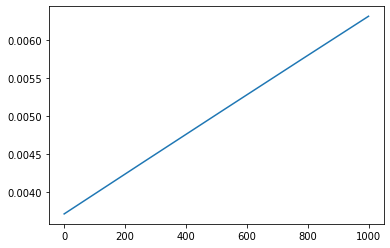

In [150]:
plt.plot(output[['AFNO3-']])

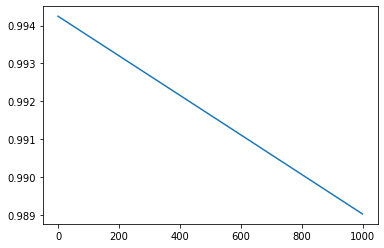

In [151]:
plt.plot(output[['AFNO2-']])

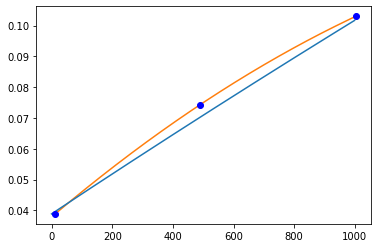

In [152]:
plt.plot(n2o_46)
x = timepoints.x
y = timepoints['46N2O']
plt.plot(x,y,'bo')
plt.plot(x_fine,interp.interp1d(x,y,kind="quadratic")(x_fine),zorder=0)

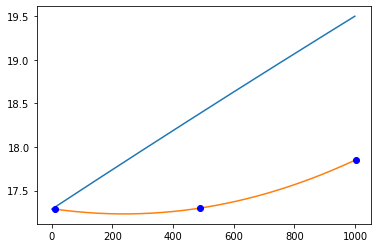

In [153]:
plt.plot(n2o_44)
x = timepoints.x
y = timepoints['44N2O']
plt.plot(x,y,'bo')
plt.plot(x_fine,interp.interp1d(x,y,kind="quadratic")(x_fine),zorder=0)

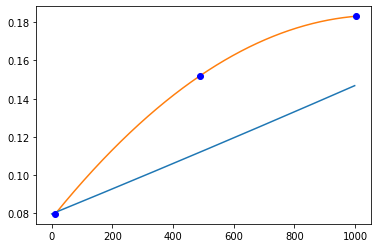

In [154]:
plt.plot(n2o_45a)
x = timepoints.x
y = timepoints['45N2Oa']
plt.plot(x,y,'bo')
plt.plot(x_fine,interp.interp1d(x,y,kind="quadratic")(x_fine),zorder=0)

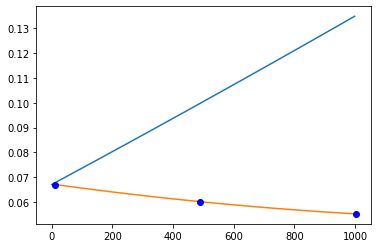

In [155]:
plt.plot(n2o_45b)
x = timepoints.x
y = timepoints['45N2Ob']
plt.plot(x,y,'bo')

plt.plot(x_fine,interp.interp1d(x,y,kind="quadratic")(x_fine),zorder=0)